## Import packages to use

In [1]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

import seaborn as sns
import statsmodels.api as sm # give you lots of stat

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import lifelines
from datetime import date
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

## Load raw dataset

In [2]:
df = pd.read_csv('../Data/data_churn_model.csv')
df.head()

,ID_Country,Country,Employee_Pay_ST,Track,Level_Cat,Level,Effective_Start_DT,Effective_Ending_DT,Termination_Reason,Birth_DT,...,Media_hora_curso,Estado,Total_number_received_Feedback,Performance_feedback_AVG,Performance_Level_CD,Performance_Level,Potential_Level_CD,Potential_Level,Track_Code,TotalNumberOfficeEmployees
0,2,MX,Active,SYINCO,5,Sr. Consultant,12/01/2001,1/29/2021,Still Active,16/09/1971,...,16.0,Activo,0.0,91.789248,2,Medium,0,No Employee info,8,1441
1,2,MX,Active,DEVELO,5,Sr. Consultant,8/23/2018,1/29/2021,Still Active,10/10/1966,...,10.0,Activo,19.0,91.630000,2,Medium,0,No Employee info,3,1441
2,2,MX,Active,CONSUL,6,Manager / Master,08/01/2009,1/29/2021,Still Active,03/09/1972,...,2.0,Activo,0.0,91.789248,0,High,0,No Employee info,2,1441
3,2,MX,Active,MNGSER,3,Experienced Consultant,11/16/2017,1/29/2021,Still Active,22/11/1970,...,14.0,Activo,0.0,91.789248,2,Medium,0,No Employee info,4,1441
4,2,MX,Active,PROJCT,6,Manager / Master,10/01/1995,1/29/2021,Still Active,25/06/1974,...,4.0,Activo,2.0,50.000000,2,Medium,1,RISING TALENT,5,1441


## Discard non-meaningful features for the analysis

##### 1)  Gender
##### 2)  Effective Start Date
##### 3)  Effectivo Ending Date
##### 4)  Marital_ST
##### 5)  DateOfBirth
##### 6)  Proportional_Days
##### 7)  Days_Taken
##### 8)  2019
##### 9)  2020

In [3]:
DropColumns = ['Gender','Effective_Start_DT','Effective_Ending_DT','Marital_ST','Birth_DT','Proportional_Days','Days_Taken','2019','2020']
df.drop(DropColumns, axis=1, inplace=True)

## Derive the Churn column

In [4]:
df.loc[df['Termination_Reason'] == 'Still Active', 'Churn'] = 0
df.loc[df['Termination_Reason'] != 'Still Active', 'Churn'] = 1


## Filter all the records with Months Worked <= 72

In [5]:
df['Level'].count() # Count before filtering by Months Worked

3429

In [6]:
df = df[df['Months_Worked'] <= 72]

In [7]:
df['Months_Worked'].unique()

array([29, 38, 32, 27, 26, 28,  3, 35, 42, 40, 65, 49, 12, 55, 47, 46, 71,
       34, 43, 21, 17, 51, 23, 60,  5, 64, 30, 48, 19, 67, 18, 37, 61, 10,
       33, 39, 36, 63, 53, 20, 52, 72, 57, 69, 68, 41, 62, 16, 59, 58, 56,
       54,  9, 11, 50, 45, 44, 15, 14, 25, 31, 24, 22,  4, 13,  8,  7,  6,
        2,  1,  0, 66, 70], dtype=int64)

## Classify the Level with values M=Managers and T=Technicals in new column TypeEmployee

In [8]:
df['Level'].count() # Count before the analysis by type of employee MANAGER or TECHNICAL


2760

In [9]:
TypeManager = ['Associate Director','Manager / Master','Sr. Manager / SME']
TypeTechnical = ['Analyst','Consultant','Experienced Consultant','Project / Technical Lead','Sr. Consultant']
df = df[df['Level'].isin(TypeTechnical)] # Change the variable to obtain a different analysis
df['Level'].count()


2627

## Calculate the Churn proportion

In [10]:
df['Churn'].unique()

array([0., 1.])

In [11]:
item_counts = df["Churn"].value_counts()
print(item_counts)

0.0    1740
1.0     887
Name: Churn, dtype: int64


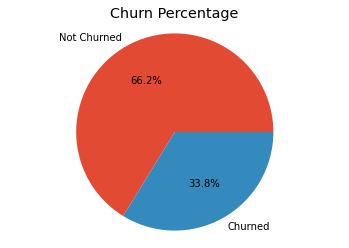

In [12]:
churn_labels = 'Not Churned', 'Churned'
plt.pie(item_counts, labels = churn_labels, autopct='%1.1f%%')
plt.title('Churn Percentage')
plt.axis('equal')
plt.savefig('piechart.jpg')
plt.show()

## Analyze the data by features

In [13]:
print(df.groupby("Prime_Skills")["Churn"].count())

Prime_Skills
.NET DEVELOPER                                                        364
ANGULAR                                                                48
BUSINESS CONSULTANT (PMO + PROCESSES + CHANGE MGT + BUSINESS CASE)     52
FINANCE                                                                 1
FUNCTIONAL ANALYST                                                    134
INFORMATICA POWERCENTER                                                24
IT                                                                     61
JAVA                                                                  335
JIRA (ZEPHYR)                                                          70
LINES OF SERVICES MANAGER                                               2
MICROFOCUS QC/ALM                                                     125
MICROSOFT DYNAMICS 365                                                 31
ORACLE                                                                 47
Other                    

In [14]:
print(df.groupby("Prime_Skills")["Churn"].sum())

Prime_Skills
.NET DEVELOPER                                                        138.0
ANGULAR                                                                17.0
BUSINESS CONSULTANT (PMO + PROCESSES + CHANGE MGT + BUSINESS CASE)     33.0
FINANCE                                                                 0.0
FUNCTIONAL ANALYST                                                     46.0
INFORMATICA POWERCENTER                                                10.0
IT                                                                     10.0
JAVA                                                                  125.0
JIRA (ZEPHYR)                                                          15.0
LINES OF SERVICES MANAGER                                               0.0
MICROFOCUS QC/ALM                                                      66.0
MICROSOFT DYNAMICS 365                                                  8.0
ORACLE                                                                 20.0

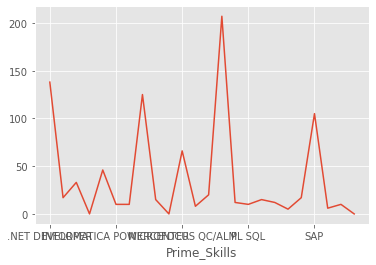

In [15]:
df_by_pskill = df.groupby("Prime_Skills")["Churn"].sum()
df_by_pskill.plot()

### ENCODE column PRIME SKILLS

##### 1=NET DEVELOPER {.NET DEVELOPER[0] + ANGULAR[1] + PHP[14]}
##### 2=JAVA {JAVA[7]}
##### 3=APP {MICROFOCUS QC/ALM[10] + MICROSOFT DYNAMICS 365[11]}
##### 4=OTHER TECHNICAL SKILLS {INFORMATICA POWERCENTER[5]+IT[6]+ORACLE[12]+PL SQL[15]+SALESFORCE[19]+TELCO[21]}
##### 5=SAP {SAP[5]}
##### 6=OTHER ADMINISTRATIVE SKILLS {BUSINESS CONSULTANT (PMO + PROCESSES + CHANGE MGT + BUSINESS CASE)[2]+FINANCE[3]+FUNCTIONAL ANALYST[4]+JIRA (ZEPHYR)[8]+LINES OF SERVICES MANAGER[9]+PMO[16]+PROJECT LEADER[17]+PROJECT MANAGER[18]+USER EXPERIENCE DESIGNER (UX)[22]+VERTICAL MANAGER[23]}
##### 7=Other[13]

In [16]:
def categorizar(fila):
    valor_actual = fila.Prime_Skills_CD
    if valor_actual in [0,1,14]:
        return 'PS_NetDeveloper'
    elif valor_actual in [7]:
        return 'PS_JAVA'    
    elif valor_actual in [10,11]:
        return 'PS_App'
    elif valor_actual in [5,6,12,15,19,21]:
        return 'PS_OtherTechnicalSkills'
    elif valor_actual in [20]:
        return 'PS_SAP'
    elif valor_actual in [2,3,4,8,9,16,17,18,22,23]:
        return 'PS_OtherAdministrativeSkills'
    elif valor_actual in [13]:
        return 'PS_Other'
    else:
        return 'PS_Desconocido'

In [17]:
df["NewPrimeSkills"] = df.apply(categorizar, axis=1)

In [18]:
df.NewPrimeSkills.unique()

array(['PS_Other', 'PS_OtherAdministrativeSkills', 'PS_NetDeveloper',
       'PS_SAP', 'PS_OtherTechnicalSkills', 'PS_App', 'PS_JAVA'],
      dtype=object)

In [19]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse='False')
enc_df = pd.DataFrame(enc.fit_transform(df[['NewPrimeSkills']]).toarray(),
                     columns=['PS_App', 'PS_JAVA', 'PS_NetDeveloper', 'PS_OtherAdministrativeSkills',
        'PS_OtherTechnicalSkills', 'PS_Other', 'PS_SAP'])
enc.categories_  

[array(['PS_App', 'PS_JAVA', 'PS_NetDeveloper', 'PS_Other',
        'PS_OtherAdministrativeSkills', 'PS_OtherTechnicalSkills',
        'PS_SAP'], dtype=object)]

In [20]:
enc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PS_App                        2627 non-null   float64
 1   PS_JAVA                       2627 non-null   float64
 2   PS_NetDeveloper               2627 non-null   float64
 3   PS_OtherAdministrativeSkills  2627 non-null   float64
 4   PS_OtherTechnicalSkills       2627 non-null   float64
 5   PS_Other                      2627 non-null   float64
 6   PS_SAP                        2627 non-null   float64
dtypes: float64(7)
memory usage: 143.8 KB


In [21]:
df = df.join(enc_df.set_index(df.index))

In [22]:
# Drop the columns after the encoding process
columnas_drop=['Prime_Skills_CD','Prime_Skills','NewPrimeSkills']
df.drop(columnas_drop, axis=1, inplace=True)

In [23]:
print(df.groupby("Track_Code")["Churn"].count())

Track_Code
0      25
2     262
3    1581
4     227
5      31
6      17
7       3
8     481
Name: Churn, dtype: int64


In [24]:
print(df.groupby("Track_Code")["Churn"].sum())

Track_Code
0      4.0
2    101.0
3    566.0
4     50.0
5     10.0
6      3.0
7      1.0
8    152.0
Name: Churn, dtype: float64


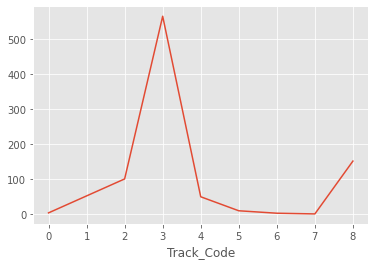

In [25]:
df_by_track = df.groupby("Track_Code")["Churn"].sum()
df_by_track.plot()

### ENCODE column TRACK
##### 1) 'ARCHTC'=Architect
##### 2) 'CONSUL'=Consultant
##### 3) 'DEVELO'=Developer
##### 4) 'MNGSER'=ManagementServices
##### 5) 'PROJCT'=Project
##### 6) 'SERMGT'=ServiceManager
##### 7) 'SUPPOR'=Support
##### 8) 'SYINCO'=SystemIntegration

In [26]:
df.Track.unique()

array(['DEVELO', 'MNGSER', 'PROJCT', 'CONSUL', 'SYINCO', 'ARCHTC',
       'SERMGT', 'SUPPOR'], dtype=object)

In [27]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse='False')
enc_df = pd.DataFrame(enc.fit_transform(df[['Track']]).toarray(),
                     columns=['TRACK_Architect', 'TRACK_Consultant', 'TRACK_Developer', 'TRACK_ManagementServices', 'TRACK_Project', 'TRACK_ServiceManager',
        'TRACK_Support', 'TRACK_SystemIntegration'])
enc.categories_  

[array(['ARCHTC', 'CONSUL', 'DEVELO', 'MNGSER', 'PROJCT', 'SERMGT',
        'SUPPOR', 'SYINCO'], dtype=object)]

In [28]:
enc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TRACK_Architect           2627 non-null   float64
 1   TRACK_Consultant          2627 non-null   float64
 2   TRACK_Developer           2627 non-null   float64
 3   TRACK_ManagementServices  2627 non-null   float64
 4   TRACK_Project             2627 non-null   float64
 5   TRACK_ServiceManager      2627 non-null   float64
 6   TRACK_Support             2627 non-null   float64
 7   TRACK_SystemIntegration   2627 non-null   float64
dtypes: float64(8)
memory usage: 164.3 KB


In [29]:
df = df.join(enc_df.set_index(df.index))

In [30]:
# Drop the columns after the encoding process
columnas_drop=['Track','Track_Code']
df.drop(columnas_drop, axis=1, inplace=True)

In [31]:
print(df.groupby("Country")["Churn"].count())

Country
AR     530
BR      62
CL     118
CO      47
CZ      30
ES     615
IN      11
MX    1179
PE      24
US      11
Name: Churn, dtype: int64


In [32]:
print(df.groupby("Country")["Churn"].sum())

Country
AR    226.0
BR     14.0
CL     46.0
CO     13.0
CZ     19.0
ES    223.0
IN      1.0
MX    334.0
PE      7.0
US      4.0
Name: Churn, dtype: float64


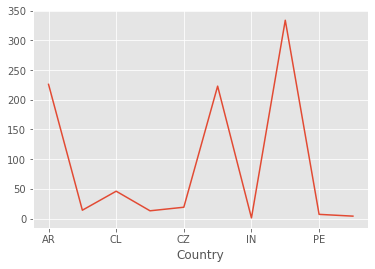

In [33]:
df_by_Country = df.groupby("Country")["Churn"].sum()
df_by_Country.plot()

In [34]:
print(df.groupby("Months_Worked")["Churn"].count())

Months_Worked
0     15
1     25
2     54
3     61
4     57
      ..
68    11
69     6
70     6
71     8
72     9
Name: Churn, Length: 73, dtype: int64


In [35]:
print(df.groupby("Months_Worked")["Churn"].sum())

Months_Worked
0     15.0
1     25.0
2     30.0
3     25.0
4     18.0
      ... 
68     2.0
69     1.0
70     3.0
71     1.0
72     3.0
Name: Churn, Length: 73, dtype: float64


In [36]:
df_by_month = df.groupby("Months_Worked")["Churn"].sum()

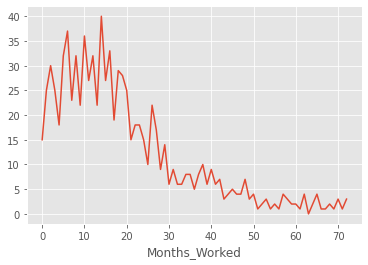

In [37]:
df_by_month.plot()

In [38]:
print(df.groupby("Edad")["Churn"].count())

Edad
18      1
19      1
20      4
21      9
22     30
23     60
24     80
25    125
26    148
27    185
28    180
29    157
30    187
31    129
32    144
33    147
34     95
35    110
36    110
37     94
38     78
39     67
40     62
41     47
42     42
43     41
44     45
45     36
46     26
47     37
48     22
49     24
50     24
51     16
52     10
53     11
54      9
55     10
56      8
57      4
58      6
59      1
60      2
61      2
64      1
Name: Churn, dtype: int64


In [39]:
print(df.groupby("Edad")["Churn"].sum())

Edad
18     1.0
19     0.0
20     0.0
21     1.0
22    11.0
23    20.0
24    30.0
25    40.0
26    65.0
27    69.0
28    73.0
29    68.0
30    61.0
31    34.0
32    59.0
33    38.0
34    33.0
35    29.0
36    38.0
37    32.0
38    26.0
39    24.0
40    16.0
41    16.0
42    14.0
43    15.0
44    11.0
45     7.0
46     4.0
47     8.0
48     7.0
49     8.0
50     8.0
51     5.0
52     2.0
53     4.0
54     2.0
55     2.0
56     2.0
57     0.0
58     2.0
59     0.0
60     0.0
61     2.0
64     0.0
Name: Churn, dtype: float64


In [40]:
df_by_age = df.groupby("Edad")["Churn"].sum()

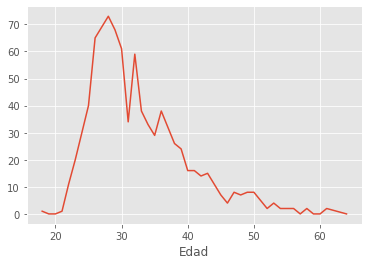

In [41]:
df_by_age.plot()

In [42]:
print(df.groupby("Department")["Churn"].count())

Department
303       22
D72       33
DH3       26
H48       39
Other    530
S04      180
S48       27
S51       89
S63      280
S64      783
S65       34
S66       57
S73       37
S76      230
T22       30
T25       59
T45       52
T57       56
T60       35
ZZ3       28
Name: Churn, dtype: int64


In [43]:
print(df.groupby("Department")["Churn"].sum())

Department
303        2.0
D72        6.0
DH3        0.0
H48        1.0
Other    300.0
S04        0.0
S48       27.0
S51        6.0
S63      280.0
S64       34.0
S65       34.0
S66       57.0
S73       37.0
S76       55.0
T22       30.0
T25        1.0
T45        6.0
T57        7.0
T60        4.0
ZZ3        0.0
Name: Churn, dtype: float64


### Combine the Increase columns in one

In [44]:
print(df.groupby("Increase_2018_2019")["Churn"].count())

Increase_2018_2019
0.000000     2546
3.758906       80
47.500000       1
Name: Churn, dtype: int64


In [45]:
print(df.groupby("Increase_2018_2019")["Churn"].sum())

Increase_2018_2019
0.000000     887.0
3.758906       0.0
47.500000      0.0
Name: Churn, dtype: float64


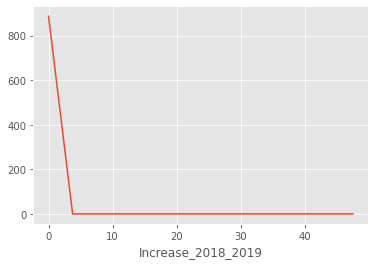

In [46]:
df_by_incr1 = df.groupby("Increase_2018_2019")["Churn"].sum()
df_by_incr1.plot()

In [47]:
print(df.groupby("Increase_2019_2020")["Churn"].sum())

Increase_2019_2020
0.000000      602.0
18.000000       0.0
18.656007       0.0
20.000000     262.0
21.000000       0.0
              ...  
89.000000       0.0
91.000000       0.0
92.000000       0.0
96.000000       0.0
100.000000      1.0
Name: Churn, Length: 62, dtype: float64


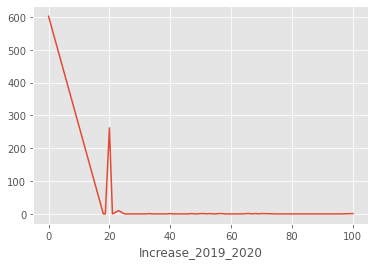

In [48]:
df_by_incr2 = df.groupby("Increase_2019_2020")["Churn"].sum()
df_by_incr2.plot()

In [49]:
df['Avg_Increase'] = df[['Increase_2018_2019', 'Increase_2019_2020']].mean(axis=1)


In [50]:
print(df.groupby('Avg_Increase')["Churn"].sum())

Avg_Increase
0.000000     602.0
9.000000       0.0
10.000000    262.0
10.500000      0.0
11.207457      0.0
             ...  
44.500000      0.0
45.500000      0.0
46.000000      0.0
48.000000      0.0
50.000000      1.0
Name: Churn, Length: 63, dtype: float64


In [51]:
# Cleanup the columns after averaging them into one
df.drop(['Increase_2018_2019', 'Increase_2019_2020'], axis=1, inplace=True)

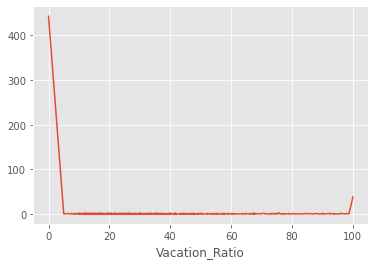

In [52]:
df_by_vacation = df.groupby("Vacation_Ratio")["Churn"].sum()
df_by_vacation.plot()

In [53]:
print(df.groupby("Marital_CD")["Churn"].count())

Marital_CD
1    1965
2     512
3     107
4      40
5       3
Name: Churn, dtype: int64


In [54]:
print(df.groupby("Level")["Churn"].count())

Level
Analyst                     631
Consultant                  599
Experienced Consultant      638
Project / Technical Lead     74
Sr. Consultant              685
Name: Churn, dtype: int64


In [55]:
print(df.groupby("Level")["Churn"].sum())

Level
Analyst                     245.0
Consultant                  206.0
Experienced Consultant      195.0
Project / Technical Lead     19.0
Sr. Consultant              222.0
Name: Churn, dtype: float64


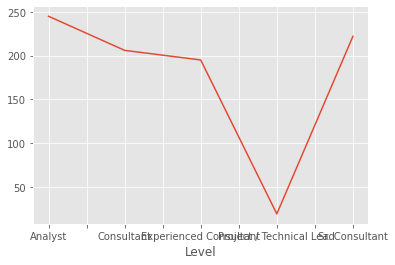

In [56]:
df_by_level = df.groupby("Level")["Churn"].sum()
df_by_level.plot()

### ENCODE column LEVEL

##### 1=Analyst
##### 2=Consultant
##### 3=ExperiencedConsultant
##### 4=Project_TechnicalLead
##### 5=SrConsultant
##### 6=Managers

In [57]:
df.Level.unique()

array(['Sr. Consultant', 'Experienced Consultant',
       'Project / Technical Lead', 'Consultant', 'Analyst'], dtype=object)

In [58]:
# Convertimos a nombres validos para las columnas
df.loc[df['Level'] == 'Sr. Consultant', 'Level_STD'] = 'LEVEL_SrConsultant'
df.loc[df['Level'] == 'Experienced Consultant', 'Level_STD'] = 'LEVEL_ExperiencedConsultant'
df.loc[df['Level'] == 'Project / Technical Lead', 'Level_STD'] = 'LEVEL_Project_TechnicalLead'
df.loc[df['Level'] == 'Analyst', 'Level_STD'] = 'LEVEL_Analyst'
df.loc[df['Level'] == 'Consultant', 'Level_STD'] = 'LEVEL_Consultant'
df.loc[df['Level'] == 'Associate Director', 'Level_STD'] = 'LEVEL_Managers'
df.loc[df['Level'] == 'Manager / Master', 'Level_STD'] = 'LEVEL_Managers'
df.loc[df['Level'] == 'Sr. Manager / SME', 'Level_STD'] = 'LEVEL_Managers'

In [59]:
DropColumns = ['Level','Level_Cat','Level_Cat.1']
df.drop(DropColumns, axis=1, inplace=True)

In [60]:
df.Level_STD.unique()

array(['LEVEL_SrConsultant', 'LEVEL_ExperiencedConsultant',
       'LEVEL_Project_TechnicalLead', 'LEVEL_Consultant', 'LEVEL_Analyst'],
      dtype=object)

In [61]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse='False')
enc_df = pd.DataFrame(enc.fit_transform(df[['Level_STD']]).toarray(),
                     columns=['LEVEL_Analyst', 'LEVEL_Consultant', 'LEVEL_ExperiencedConsultant',
        'LEVEL_Project_TechnicalLead', 'LEVEL_SrConsultant'])
enc.categories_  

[array(['LEVEL_Analyst', 'LEVEL_Consultant', 'LEVEL_ExperiencedConsultant',
        'LEVEL_Project_TechnicalLead', 'LEVEL_SrConsultant'], dtype=object)]

In [62]:
enc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   LEVEL_Analyst                2627 non-null   float64
 1   LEVEL_Consultant             2627 non-null   float64
 2   LEVEL_ExperiencedConsultant  2627 non-null   float64
 3   LEVEL_Project_TechnicalLead  2627 non-null   float64
 4   LEVEL_SrConsultant           2627 non-null   float64
dtypes: float64(5)
memory usage: 102.7 KB


In [63]:
df = df.join(enc_df.set_index(df.index))

In [64]:
# Drop the columns after the Encode process
columnas_drop=['Level_STD']
df.drop(columnas_drop, axis=1, inplace=True)

### ENCODE column TERMINATION REASON

In [65]:
print(df.groupby("Termination_Reason")["Churn"].count())

Termination_Reason
Still Active                     1740
Vol - Compensation & Benefits     148
Vol - Job Abandonment               1
Vol - Other                        38
Vol - Personal                    126
Vol - Project Discomfort           97
Vol - Supervisor / Leadership       9
Vol - Training & Career Dev       451
Vol - Transfer NEORIS Office        2
Vol - Transfer to CEMEX             9
Vol - Transfer to client            5
Vol - Work Environment              1
Name: Churn, dtype: int64


In [66]:
df['Termination_Code'] = df['Termination_Reason']
df['Termination_Code'] = df['Termination_Code'].replace(['Still Active','Vol - Compensation & Benefits','Vol - Personal','Vol - Project Discomfort','Vol - Training & Career Dev'],['V_StillActive','V_CompensationAndBenefits','V_Personal','V_ProjectDiscomfort','V_TrainingAndCareer'])
df['Termination_Code'] = df['Termination_Code'].replace(['Vol - Job Abandonment','Vol - Supervisor / Leadership','Vol - Other','Vol - Transfer NEORIS Office','Vol - Transfer to CEMEX','Vol - Transfer to client', 'Vol - Work Environment'],'V_OtherReasons')
df['Termination_Code'].unique()

array(['V_StillActive', 'V_TrainingAndCareer', 'V_OtherReasons',
       'V_ProjectDiscomfort', 'V_Personal', 'V_CompensationAndBenefits'],
      dtype=object)

In [67]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse='False')
enc_df = pd.DataFrame(enc.fit_transform(df[['Termination_Code']]).toarray(),
                     columns=['V_OtherReasons', 'V_CompensationAndBenefits', 'V_Personal',
        'V_ProjectDiscomfort', 'V_StillActive', 'V_TrainingAndCareer'])
enc.categories_  

[array(['V_CompensationAndBenefits', 'V_OtherReasons', 'V_Personal',
        'V_ProjectDiscomfort', 'V_StillActive', 'V_TrainingAndCareer'],
       dtype=object)]

In [68]:
enc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   V_OtherReasons             2627 non-null   float64
 1   V_CompensationAndBenefits  2627 non-null   float64
 2   V_Personal                 2627 non-null   float64
 3   V_ProjectDiscomfort        2627 non-null   float64
 4   V_StillActive              2627 non-null   float64
 5   V_TrainingAndCareer        2627 non-null   float64
dtypes: float64(6)
memory usage: 123.3 KB


In [69]:
df = df.join(enc_df.set_index(df.index))

In [70]:
# Drop the columns after the Encode process
columnas_drop=['Termination_Reason', 'Termination_Code']
df.drop(columnas_drop, axis=1, inplace=True)

### Perform additional column cleanup 

In [71]:
DropColumns = ['Country','Employee_Pay_ST','Department','Estado','Performance_Level','Potential_Level']
df.drop(DropColumns, axis=1, inplace=True)

In [72]:
fill_nan_cols = ['Region', 'Bonus_2018', 'Bonus_2019']
df[fill_nan_cols] = df[fill_nan_cols].fillna(0)


In [73]:
df[df['Cost_Centers']<0]=0
df[df['Cost_Centers']<0]

,ID_Country,Edad,Marital_CD,SBR_AMT,SCR_AMT,Region,Office,Area,Division,Department_CD,...,LEVEL_Consultant,LEVEL_ExperiencedConsultant,LEVEL_Project_TechnicalLead,LEVEL_SrConsultant,V_OtherReasons,V_CompensationAndBenefits,V_Personal,V_ProjectDiscomfort,V_StillActive,V_TrainingAndCareer


## Feature importance Analysis

#### Split the data in X and y for Statistical Feature importance Analysis

In [74]:
X,y = df.drop(['Churn'], axis = 1), df.Churn

In [75]:
y.sum()

887.0

#### Use Tree based models for Feature Analysis

In [76]:
model = DecisionTreeClassifier()

In [77]:
model.fit(X, y)

DecisionTreeClassifier()

In [78]:
importance = model.feature_importances_

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00509
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

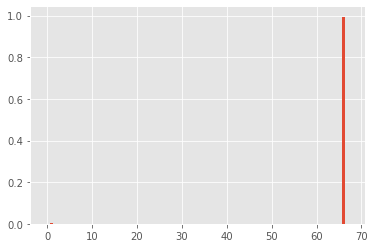

In [79]:
for i,v in enumerate(importance):
     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature: 0, Score: 0.00282
Feature: 1, Score: 0.00100
Feature: 2, Score: 0.00101
Feature: 3, Score: 0.00138
Feature: 4, Score: 0.00126
Feature: 5, Score: 0.00682
Feature: 6, Score: 0.00309
Feature: 7, Score: 0.00056
Feature: 8, Score: 0.00168
Feature: 9, Score: 0.00683
Feature: 10, Score: 0.00052
Feature: 11, Score: 0.00361
Feature: 12, Score: 0.00131
Feature: 13, Score: 0.00237
Feature: 14, Score: 0.00651
Feature: 15, Score: 0.00406
Feature: 16, Score: 0.00130
Feature: 17, Score: 0.00146
Feature: 18, Score: 0.00127
Feature: 19, Score: 0.00067
Feature: 20, Score: 0.00064
Feature: 21, Score: 0.00162
Feature: 22, Score: 0.00020
Feature: 23, Score: 0.00007
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00027
Feature: 26, Score: 0.00027
Feature: 27, Score: 0.00064
Feature: 28, Score: 0.00025
Feature: 29, Score: 0.00072
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00217
Feature: 33, Score: 0.00466
Feature: 34, Score: 0.00676
Feature: 35, Score: 0.00774
Fe

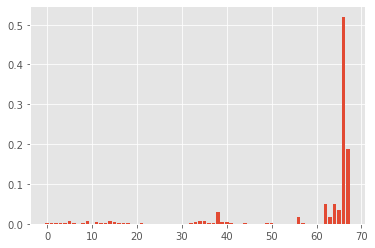

In [80]:
model = ExtraTreesClassifier()
model.fit(X,y)
importance = model.feature_importances_
for i,v in enumerate(importance):
     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


Feature: 0, Score: 0.00584
Feature: 1, Score: 0.00329
Feature: 2, Score: 0.00069
Feature: 3, Score: 0.00361
Feature: 4, Score: 0.00348
Feature: 5, Score: 0.01288
Feature: 6, Score: 0.00392
Feature: 7, Score: 0.00024
Feature: 8, Score: 0.00477
Feature: 9, Score: 0.02914
Feature: 10, Score: 0.00016
Feature: 11, Score: 0.00198
Feature: 12, Score: 0.00260
Feature: 13, Score: 0.00496
Feature: 14, Score: 0.01273
Feature: 15, Score: 0.00808
Feature: 16, Score: 0.00375
Feature: 17, Score: 0.00249
Feature: 18, Score: 0.01116
Feature: 19, Score: 0.00150
Feature: 20, Score: 0.00138
Feature: 21, Score: 0.00892
Feature: 22, Score: 0.00032
Feature: 23, Score: 0.00017
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00039
Feature: 26, Score: 0.00046
Feature: 27, Score: 0.00157
Feature: 28, Score: 0.00065
Feature: 29, Score: 0.00190
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00818
Feature: 33, Score: 0.01450
Feature: 34, Score: 0.01206
Feature: 35, Score: 0.00678
Fe

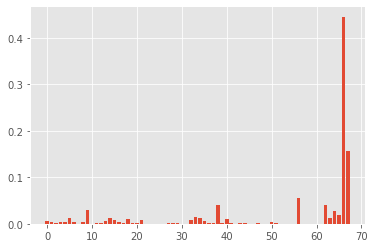

In [81]:
model = RandomForestClassifier()
model.fit(X,y)
importance = model.feature_importances_
for i,v in enumerate(importance):
     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


#### Use Chi Square analysis for Feature Importance

In [82]:
bestfeatures = SelectKBest(score_func=chi2, k=30)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 30 best features


                             Specs         Score
21               Billable_Projects  23942.851317
34              Logs_Global_Campus  20922.251915
8                         Division   6743.657354
40      TotalNumberOfficeEmployees   4260.720240
56                    Avg_Increase   4094.184591
22       Corporate_Funded_Projects   4046.485232
33              Logs_Course_Viewed   2331.607054
14                   Months_Worked   1855.096877
35                Media_hora_curso   1691.500298
18               Abscence_Projects   1459.240973
15                  Vacation_Ratio   1260.874355
25    Internal_Investment_Projects   1027.951404
66                   V_StillActive    885.470690
67             V_TrainingAndCareer    884.712514
32                   Course_Viewed    800.765234
20               Awaiting_Projects    595.838676
19        Administrative_Functions    452.945679
62                  V_OtherReasons    290.326945
16          Number_Unique_Projects    278.868510
6                   

#### Scale the data after first attempt returned unreliable results

In [83]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
bestfeatures = SelectKBest(score_func=chi2, k=30)
fit = bestfeatures.fit(X_scaled,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 30 best features


                             Specs       Score
66                   V_StillActive  885.470690
67             V_TrainingAndCareer  884.712514
62                  V_OtherReasons  290.326945
64                      V_Personal  247.170237
65             V_ProjectDiscomfort  190.281849
63       V_CompensationAndBenefits  127.508455
56                    Avg_Increase   81.883692
39              Potential_Level_CD   75.592304
38            Performance_Level_CD   59.419219
33              Logs_Course_Viewed   43.177908
34              Logs_Global_Campus   42.097086
35                Media_hora_curso   35.239590
14                   Months_Worked   25.765234
32                   Course_Viewed   17.794783
51        TRACK_ManagementServices   13.403916
41                          PS_App   13.037123
15                  Vacation_Ratio   12.608744
36  Total_number_received_Feedback   10.744808
44    PS_OtherAdministrativeSkills   10.003672
57                   LEVEL_Analyst    7.564096
8            

#### Cleanup the non relevant features after the analysis. Chi Square was chosen for the best results

In [84]:
DropColumns = ['Edad','Marital_CD','SBR_AMT','SCR_AMT','Region','Area', 'Department_CD', 'Billiability', 'Technology', 
               'Business_Unit', 'Std_Hrs_Week','Internal_Investment_Projects','Number_Unique_Project_Type',
               'Administrative_Functions','Awaiting_Projects','Corporate_Funded_Projects',
               'Cost_Centers','Indirect_Cost_Centers','Internal_Programs','Proposals','Proposals_General','Training_Programs',
               'Bonus_2018','Bonus_2019', 'ID_Country']
df.drop(DropColumns, axis=1, inplace=True)


## Execute Survival Analysis

#### First exercise with the whole dataframe

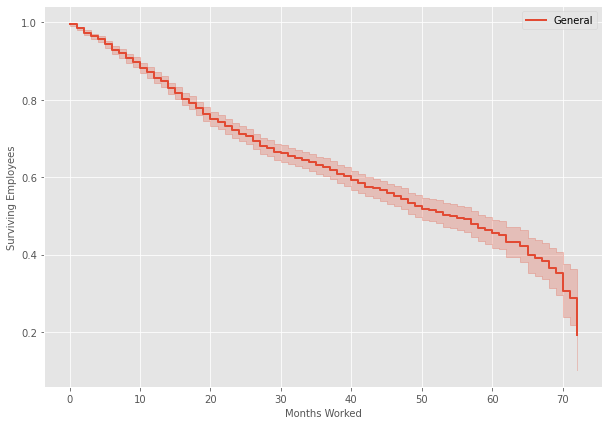

In [85]:
kmf = KaplanMeierFitter()
kmf.fit(durations = df['Months_Worked'], event_observed = df['Churn'], label='General')

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
kmf.plot(ax=ax, linewidth = 2)
ax.set_xlabel('Months Worked', size = 10)
ax.set_ylabel('Surviving Employees', size = 10)
plt.show()

In [86]:
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0,18,15,3,2627,2627
1,25,25,0,0,2609
2,54,30,24,0,2584
3,61,25,36,0,2530
4,57,18,39,0,2469
...,...,...,...,...,...
68,11,2,9,0,40
69,6,1,5,0,29
70,6,3,3,0,23


In [87]:
kmf.predict([10,20,30,40, 50, 60, 72])

10    0.882666
20    0.750096
30    0.661387
40    0.591692
50    0.517877
60    0.454675
72    0.191945
Name: General, dtype: float64

In [88]:
# Obtain the Cox Proportional Hazard coefficients for the data
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df, 'Months_Worked', event_col='Churn')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2627 total observations, 1740 right-censored observations>
             duration col = 'Months_Worked'
                event col = 'Churn'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 2627
number of events observed = 887
   partial log-likelihood = -4947.56
         time fit was run = 2021-03-05 01:45:39 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
Office                          -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
Division                         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Vacation_Ratio                  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Number_Unique_Projects          -0.04       0.96       0.01            -0.05            -0.03                 0.95                 0.97
Abscence_Projects               -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
Billable_Projects               -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Course_Viewed                    0.00       1.00       0.01            -0.01             0.01                 0.99                 1.02
Logs_Course_Viewed              -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
Logs_Global_Campus              -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Media_hora_curso                -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
Total_number_received_Feedback  -0.03       0.97       0.01            -0.05            -0.01                 0.95                 0.99
Performance_feedback_AVG         0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
Performance_Level_CD             0.09       1.09       0.04             0.01             0.17                 1.01                 1.19
Potential_Level_CD              -0.08       0.92       0.08            -0.23             0.07                 0.80                 1.07
TotalNumberOfficeEmployees       0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
PS_App                          -0.20       0.81       0.13            -0.45             0.04                 0.64                 1.04
PS_JAVA                          0.10       1.11       0.10            -0.10             0.31                 0.90                 1.36
PS_NetDeveloper                  0.06       1.07       0.10            -0.13             0.25                 0.88                 1.29
PS_OtherAdministrativeSkills    -0.07       0.93       0.09            -0.24             0.10                 0.79                 1.11
PS_OtherTechnicalSkills          0.02       1.02       0.10            -0.18             0.22                 0.83                 1.25
PS_Other                         0.01       1.01       0.12            -0.23             0.26                 0.80                 1.29
PS_SAP                           0.01       1.01       0.11            -0.20             0.22                 0.82                 1.25
TRACK_Architect                 -0.13       0.88       0.39            -0.90             0.65                 0.41                 1.91
TRACK_Consultant                -0.05       0.95       0.12            -0.29             0.19                 0.75                 1.21
TRACK_Developer               

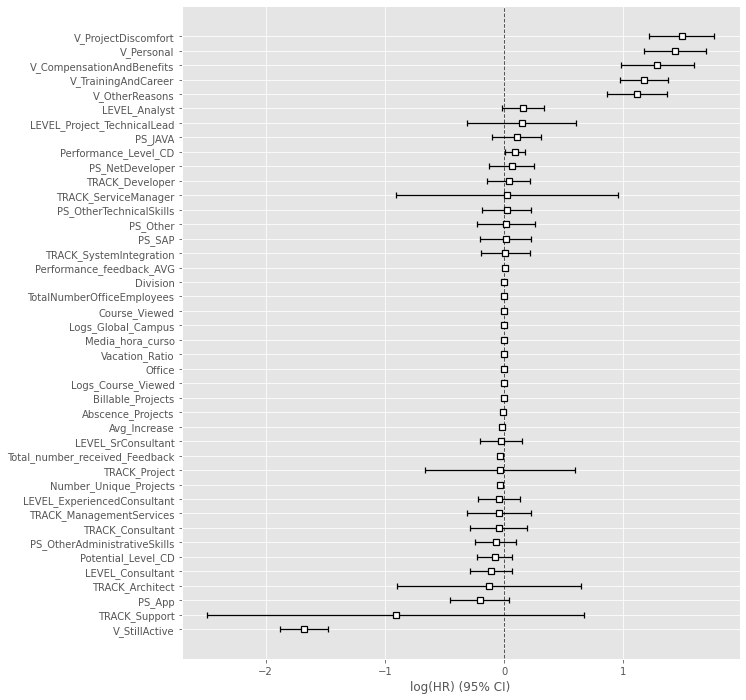

In [89]:
# Plot the CoxPH coefficients
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111)
cph.plot(ax=ax)

#### Second exercise with the Termination Reason features

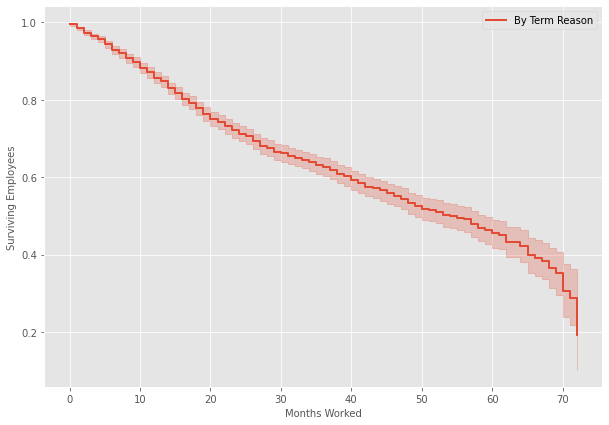

In [90]:
df_Term_Reason = df[['Months_Worked','Churn','V_StillActive', 'V_TrainingAndCareer', 'V_OtherReasons', 'V_Personal', 'V_ProjectDiscomfort', 'V_CompensationAndBenefits']]
kmf.fit(durations = df_Term_Reason['Months_Worked'], event_observed = df['Churn'], label='By Term Reason')

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
kmf.plot(ax=ax, linewidth = 2)
ax.set_xlabel('Months Worked', size = 10)
ax.set_ylabel('Surviving Employees', size = 10)
plt.show()

#### Third exercise plotting the features separately

In [91]:
def survival_features(df_in, file_in):
    ''' Function to execute the Survival Analysis for a dataframe and plot the results
    IN: dataframe with specific features
        name of the output file to save the image
    '''
    T = df_in['Months_Worked']
    E = df_in['Churn']
#    DropColumns = ['Months_Worked','Churn']
#    df_in.drop(DropColumns, axis=1, inplace=True)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    
    for column in df_in:
   # Select column contents by column name using [] operator
        if column == 'Months_Worked' or column == 'Churn':
            continue
        group = df_in[column] == 1
        kmf.fit(T[group], E[group], label=column)
        kmf.plot(ax=ax, linewidth = 2)
        ax.set_xlabel('Months Worked', size = 10)
        ax.set_ylabel('Surviving Employees', size = 10)
    filename = file_in + '.jpg'
    plt.savefig(filename)    
    plt.show()


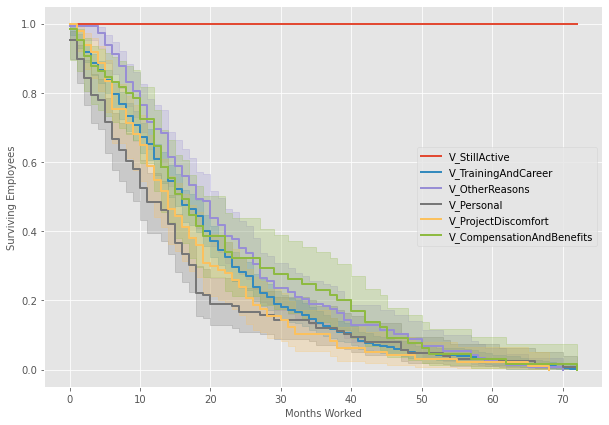

In [92]:
# Plot the Survival Analysis by the Termination Reason group of features
survival_features(df_Term_Reason, 'termreason')

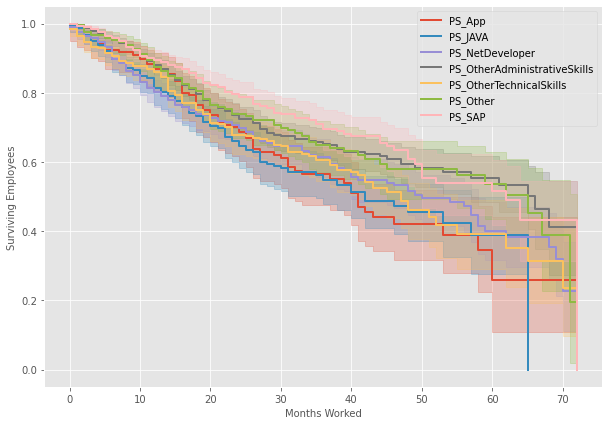

In [93]:
# Plot the Survival Analysis by the Primary Skill group of features
df_skill = df[['Months_Worked','Churn','PS_App','PS_JAVA', 'PS_NetDeveloper', 'PS_OtherAdministrativeSkills', 'PS_OtherTechnicalSkills', 'PS_Other', 'PS_SAP']]
survival_features(df_skill, 'skill')

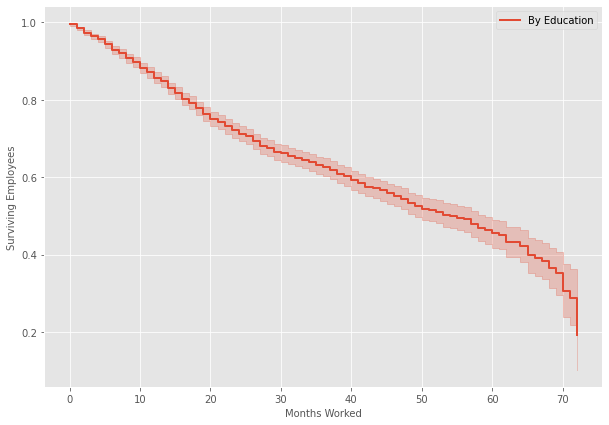

In [94]:
# Plot the Survival Analysis by the Education group of features
df_Education = df[['Months_Worked','Churn','Logs_Course_Viewed','Logs_Global_Campus', 'Media_hora_curso', 'Course_Viewed']]
kmf.fit(durations = df_Education['Months_Worked'], event_observed = df_Education['Churn'], label='By Education')
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
kmf.plot(ax=ax, linewidth = 2)
ax.set_xlabel('Months Worked', size = 10)
ax.set_ylabel('Surviving Employees', size = 10)
plt.savefig('education.jpg')
plt.show()

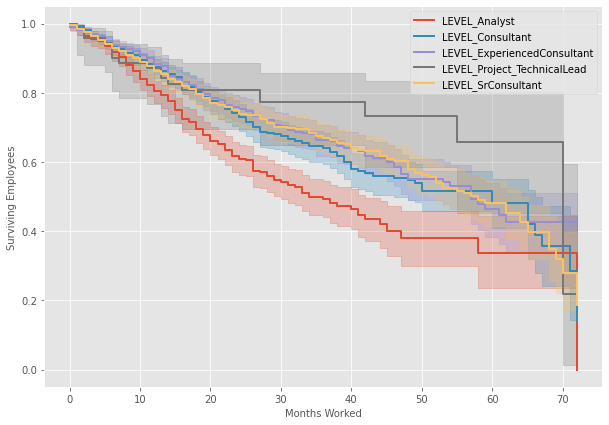

In [95]:
# Plot the Survival Analysis by the Level group of features
df_level = df[['Months_Worked','Churn','LEVEL_Analyst','LEVEL_Consultant', 'LEVEL_ExperiencedConsultant', 
               'LEVEL_Project_TechnicalLead', 'LEVEL_SrConsultant']]
survival_features(df_level, 'level')


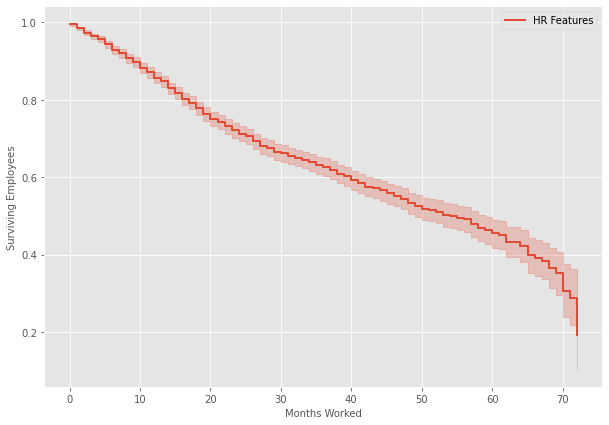

In [96]:
# Plot the Survival Analysis by the HR group of features
df_HR = df[['Months_Worked','Churn','Vacation_Ratio','Avg_Increase', 'Potential_Level_CD', 'Performance_Level_CD',
            'Total_number_received_Feedback','Abscence_Projects','Billable_Projects']]
kmf.fit(durations = df_HR['Months_Worked'], event_observed = df_HR['Churn'], label='HR Features')
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
kmf.plot(ax=ax, linewidth = 2)
ax.set_xlabel('Months Worked', size = 10)
ax.set_ylabel('Surviving Employees', size = 10)
plt.savefig('HR.jpg')
plt.show()


#### Fourth Exercise removing the Termination Reason features since the Churn is derived from them

In [97]:
df_no_Term = df
DropColumns = ['V_StillActive', 'V_TrainingAndCareer', 'V_OtherReasons', 'V_Personal', 'V_ProjectDiscomfort', 'V_CompensationAndBenefits']
df_no_Term.drop(DropColumns, axis=1, inplace=True)

In [99]:
# Obtain the Cox Proportional Hazard coefficients for the data
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df_no_Term, 'Months_Worked', event_col='Churn')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2627 total observations, 1740 right-censored observations>
             duration col = 'Months_Worked'
                event col = 'Churn'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 2627
number of events observed = 887
   partial log-likelihood = -5553.72
         time fit was run = 2021-03-05 01:48:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
Office                          -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
Division                        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Vacation_Ratio                  -0.00       1.00       0.00            -0.01            -0.00                 0.99                 1.00
Number_Unique_Projects          -0.03       0.97       0.00            -0.04            -0.02                 0.96                 0.98
Abscence_Projects               -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
Billable_Projects               -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Course_Viewed                   -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01
Logs_Course_Viewed              -0.01       0.99       0.00            -0.02            -0.00                 0.98                 1.00
Logs_Global_Campus              -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Media_hora_curso                -0.01       0.99       0.01            -0.02            -0.00                 0.98                 1.00
Total_number_received_Feedback  -0.03       0.97       0.01            -0.06            -0.01                 0.95                 0.99
Performance_feedback_AVG         0.01       1.01       0.00            -0.00             0.02                 1.00                 1.02
Performance_Level_CD             0.32       1.38       0.04             0.24             0.40                 1.27                 1.50
Potential_Level_CD              -0.23       0.79       0.07            -0.38            -0.09                 0.68                 0.92
TotalNumberOfficeEmployees       0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
PS_App                          -0.03       0.97       0.13            -0.28             0.22                 0.76                 1.24
PS_JAVA                          0.12       1.13       0.10            -0.08             0.33                 0.92                 1.39
PS_NetDeveloper                  0.07       1.07       0.10            -0.12             0.26                 0.89                 1.29
PS_OtherAdministrativeSkills    -0.14       0.87       0.09            -0.32             0.03                 0.73                 1.03
PS_OtherTechnicalSkills          0.06       1.07       0.10            -0.14             0.27                 0.87                 1.31
PS_Other                         0.09       1.09       0.12            -0.15             0.33                 0.86                 1.39
PS_SAP                          -0.06       0.95       0.11            -0.27             0.16                 0.76                 1.17
TRACK_Architect                 -0.23       0.79       0.39            -0.99             0.52                 0.37                 1.69
TRACK_Consultant                 0.11       1.11       0.12            -0.14             0.35                 0.87                 1.41
TRACK_Developer               

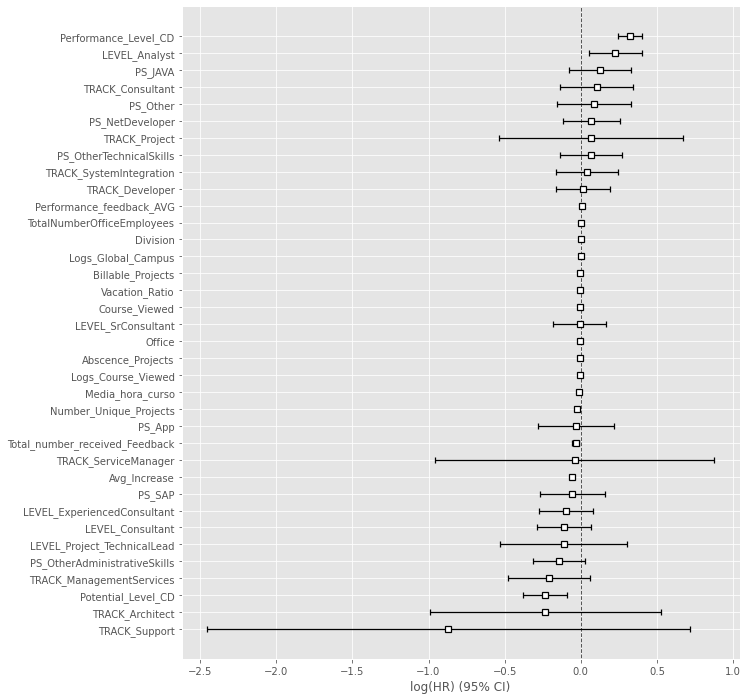

In [100]:
# Plot the CoxPH coefficients
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111)
cph.plot(ax=ax)